# **Install Libraries & Download Dataset**

In [1]:
!pip install torch torchvision torchaudio scikit-learn matplotlib pandas --quiet

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## **Now download the NYC taxi dataset + anomaly labels (from the NAB repo):**

In [2]:
# Download NYC Taxi time series (NAB)
!wget -q https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv

# Download known anomaly labels for NYC taxi
!wget -q https://raw.githubusercontent.com/numenta/NAB/master/labels/raw/known_labels_v1.0.json

print("Files downloaded:", os.listdir())


Files downloaded: ['.config', 'known_labels_v1.0.json', 'nyc_taxi.csv', 'sample_data']


## Load Data, Build Labels, Create Streaming Windows

In [3]:
# Load time series
df = pd.read_csv("nyc_taxi.csv")
df.head()


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [4]:
# Parse timestamp as datetime and set index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
values = df['value'].values.astype('float32')

# Load anomaly timestamps from JSON labels
with open("known_labels_v1.0.json", "r") as f:
    label_dict = json.load(f)

# This JSON stores anomaly timestamps per file
anomaly_timestamps = label_dict["realKnownCause/nyc_taxi.csv"]
anomaly_timestamps = [pd.to_datetime(ts) for ts in anomaly_timestamps]

# Build point-wise label array (1 if timestamp is in anomaly list, else 0)
labels_point = np.zeros(len(df), dtype=np.int64)
ts_index = df.index

anomaly_set = set(anomaly_timestamps)
for i, t in enumerate(ts_index):
    if t in anomaly_set:
        labels_point[i] = 1

print("Total points:", len(values))
print("Total anomalies:", labels_point.sum())


Total points: 10320
Total anomalies: 5


In [5]:
# Scale values
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Function: convert time series into sliding windows
def make_windows(values, labels, window_size=50):
    X = []
    y = []
    for t in range(window_size, len(values)):
        window = values[t-window_size:t]
        X.append(window)
        # Label window as anomaly if any point in the window is anomalous
        y.append(1 if labels[t-window_size:t].max() == 1 else 0)
    X = np.array(X)[:, :, None]  # shape: (N, T, 1)
    y = np.array(y)
    return X, y

WINDOW_SIZE = 50
X_windows, y_windows = make_windows(values_scaled, labels_point, window_size=WINDOW_SIZE)

print("X_windows shape:", X_windows.shape)
print("y_windows shape:", y_windows.shape)
print("Window anomaly ratio:", y_windows.mean())

X_windows shape: (10270, 50, 1)
y_windows shape: (10270,)
Window anomaly ratio: 0.024342745861733205


We’ll split early part as “train” (for supervised model) and the rest as “streaming test”.

In [6]:
# Simple split: first 30% windows as supervised train, rest as test/stream
N = len(X_windows)
split_idx = int(0.3 * N)

X_train_sup = X_windows[:split_idx]
y_train_sup = y_windows[:split_idx]

X_test_all = X_windows
y_test_all = y_windows

print("Supervised train windows:", len(X_train_sup))
print("Total windows for eval:", len(X_test_all))


Supervised train windows: 3081
Total windows for eval: 10270


# **Define Shared Encoder + Models (Supervised, AE, SSL)**

In [7]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=64, emb_dim=32):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, emb_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        # x: (B, T, C) -> (B, C, T)
        x = x.permute(0, 2, 1)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        z = self.fc(x)
        return z

class SupervisedClassifier(nn.Module):
    def __init__(self, window_size=50, emb_dim=32):
        super().__init__()
        self.encoder = CNNEncoder(in_channels=1, hidden_dim=64, emb_dim=emb_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return logits

class Autoencoder(nn.Module):
    def __init__(self, window_size=50, emb_dim=32):
        super().__init__()
        self.window_size = window_size
        self.encoder = CNNEncoder(in_channels=1, hidden_dim=64, emb_dim=emb_dim)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, window_size)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

class SSLModel(nn.Module):
    def __init__(self, window_size=50, emb_dim=32):
        super().__init__()
        self.window_size = window_size
        self.encoder = CNNEncoder(in_channels=1, hidden_dim=64, emb_dim=emb_dim)
        self.recon_head = nn.Linear(emb_dim, window_size)
        self.pred_head = nn.Linear(emb_dim, emb_dim)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.recon_head(z)
        pred_z_next = self.pred_head(z)
        return z, recon, pred_z_next


# **Supervised Baseline: Train & Evaluate**

In [8]:
BATCH_SIZE = 64

# Prepare supervised train loader
train_sup_dataset = TensorDataset(
    torch.from_numpy(X_train_sup).float(),
    torch.from_numpy(y_train_sup).long()
)
train_sup_loader = DataLoader(train_sup_dataset, batch_size=BATCH_SIZE, shuffle=True)

# For full-test evaluation (all windows)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_all).float(),
    torch.from_numpy(y_test_all).long()
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

sup_model = SupervisedClassifier(window_size=WINDOW_SIZE, emb_dim=32).to(device)
optimizer_sup = torch.optim.Adam(sup_model.parameters(), lr=1e-3)
criterion_sup = nn.CrossEntropyLoss()


In [9]:
# Train supervised classifier on early segment
EPOCHS_SUP = 5

sup_model.train()
for epoch in range(EPOCHS_SUP):
    total_loss = 0.0
    for xb, yb in train_sup_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = sup_model(xb)
        loss = criterion_sup(logits, yb)

        optimizer_sup.zero_grad()
        loss.backward()
        optimizer_sup.step()
        total_loss += loss.item() * len(xb)
    print(f"[Supervised] Epoch {epoch+1}/{EPOCHS_SUP}, Loss: {total_loss/len(train_sup_dataset):.4f}")


[Supervised] Epoch 1/5, Loss: 0.3470
[Supervised] Epoch 2/5, Loss: 0.0005
[Supervised] Epoch 3/5, Loss: 0.0002
[Supervised] Epoch 4/5, Loss: 0.0001
[Supervised] Epoch 5/5, Loss: 0.0001


In [10]:
# Evaluate supervised model for anomaly detection (treat class 1 as anomaly)
sup_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = sup_model(xb)
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of anomaly
        preds = (probs.cpu().numpy() > 0.5).astype(int)
        all_preds.append(preds)
        all_labels.append(yb.numpy())

sup_preds = np.concatenate(all_preds)
sup_labels = np.concatenate(all_labels)

sup_f1 = f1_score(sup_labels, sup_preds, zero_division=0)
sup_prec = precision_score(sup_labels, sup_preds, zero_division=0)
sup_rec = recall_score(sup_labels, sup_preds, zero_division=0)

print("Supervised baseline:")
print("  F1:", sup_f1)
print("  Precision:", sup_prec)
print("  Recall:", sup_rec)


Supervised baseline:
  F1: 0.0
  Precision: 0.0
  Recall: 0.0


# **Autoencoder Baseline: Train & Evaluate**

In [11]:
ae_model = Autoencoder(window_size=WINDOW_SIZE, emb_dim=32).to(device)
optimizer_ae = torch.optim.Adam(ae_model.parameters(), lr=1e-3)
criterion_ae = nn.MSELoss()

# For unsupervised AE training, use EARLY normal windows only (where label==0)
normal_mask = (y_windows[:split_idx] == 0)
X_train_ae = X_windows[:split_idx][normal_mask]

train_ae_dataset = TensorDataset(torch.from_numpy(X_train_ae).float())
train_ae_loader = DataLoader(train_ae_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [12]:
EPOCHS_AE = 5

ae_model.train()
for epoch in range(EPOCHS_AE):
    total_loss = 0.0
    for (xb,) in train_ae_loader:
        xb = xb.to(device)
        recon, _ = ae_model(xb)
        target = xb.squeeze(-1)  # (B, T)
        loss = criterion_ae(recon, target)
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item() * len(xb)
    print(f"[AE] Epoch {epoch+1}/{EPOCHS_AE}, Loss: {total_loss/len(train_ae_dataset):.4f}")


[AE] Epoch 1/5, Loss: 0.8665
[AE] Epoch 2/5, Loss: 0.8262
[AE] Epoch 3/5, Loss: 0.8098
[AE] Epoch 4/5, Loss: 0.7390
[AE] Epoch 5/5, Loss: 0.6347


In [13]:
# AE anomaly scores: reconstruction error
ae_model.eval()
all_scores = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        recon, _ = ae_model(xb)
        target = xb.squeeze(-1)
        mse = ((recon - target) ** 2).mean(dim=1)  # (B,)
        all_scores.append(mse.cpu().numpy())
        all_labels.append(yb.numpy())

ae_scores = np.concatenate(all_scores)
ae_labels = np.concatenate(all_labels)

# Choose threshold as, for example, 95th percentile of AE scores on early normal windows
with torch.no_grad():
    X_early = torch.from_numpy(X_windows[:split_idx]).float().to(device)
    recon_e, _ = ae_model(X_early)
    target_e = X_early.squeeze(-1)
    mse_e = ((recon_e - target_e) ** 2).mean(dim=1).cpu().numpy()
threshold_ae = np.percentile(mse_e, 95)

ae_preds = (ae_scores > threshold_ae).astype(int)

ae_f1 = f1_score(ae_labels, ae_preds, zero_division=0)
ae_prec = precision_score(ae_labels, ae_preds, zero_division=0)
ae_rec = recall_score(ae_labels, ae_preds, zero_division=0)

print("Autoencoder baseline:")
print("  F1:", ae_f1)
print("  Precision:", ae_prec)
print("  Recall:", ae_rec)


Autoencoder baseline:
  F1: 0.10315695864828812
  Precision: 0.058029014507253625
  Recall: 0.464


# **SSL Model: Train & Evaluate**

We’ll train SSL with:

Masked reconstruction loss

Predictive coding loss (predict next-window embedding)

In [14]:
ssl_model = SSLModel(window_size=WINDOW_SIZE, emb_dim=32).to(device)
optimizer_ssl = torch.optim.Adam(ssl_model.parameters(), lr=1e-3)
mse = nn.MSELoss()

# For SSL training, we can also focus on early segment (mostly normal), but *without using labels*
X_train_ssl = X_windows[:split_idx]
train_ssl_dataset = TensorDataset(torch.from_numpy(X_train_ssl).float())
train_ssl_loader = DataLoader(train_ssl_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
EPOCHS_SSL = 5
MASK_RATIO = 0.3

ssl_model.train()
for epoch in range(EPOCHS_SSL):
    total_loss = 0.0
    count = 0
    for (xb,) in train_ssl_loader:
        xb = xb.to(device)          # (B, T, 1)
        B, T, _ = xb.shape

        # Mask some positions for masked reconstruction
        mask = (torch.rand(B, T, device=device) < MASK_RATIO)
        xb_masked = xb.clone()
        xb_masked[mask.unsqueeze(-1)] = 0.0

        # Build "future" windows by shifting one step in dataset index (approx)
        # For simplicity, here we just use the same xb as "future" proxy.
        # In a more precise setup, you would offset by +1 in the time axis across dataset.
        z, recon, pred_z_next = ssl_model(xb_masked)
        # Use current z as pseudo-target for next (simple approximation)
        z_next_target = z.detach()

        # Reconstruction loss (masked)
        target = xb.squeeze(-1)  # (B, T)
        loss_recon = mse(recon, target)

        # Predictive coding loss
        loss_pred = mse(pred_z_next, z_next_target)

        loss = loss_recon + loss_pred

        optimizer_ssl.zero_grad()
        loss.backward()
        optimizer_ssl.step()

        total_loss += loss.item() * len(xb)
        count += len(xb)
    print(f"[SSL] Epoch {epoch+1}/{EPOCHS_SSL}, Loss: {total_loss/count:.4f}")


[SSL] Epoch 1/5, Loss: 0.8893
[SSL] Epoch 2/5, Loss: 0.8497
[SSL] Epoch 3/5, Loss: 0.8310
[SSL] Epoch 4/5, Loss: 0.8234
[SSL] Epoch 5/5, Loss: 0.7997


Now we use SSL for anomaly detection:
We’ll combine reconstruction error and predictive coding error as an anomaly score.

In [16]:
# Evaluate SSL anomaly scores
ssl_model.eval()
all_scores = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        B, T, _ = xb.shape

        # Masked input for evaluation (same masking scheme)
        mask = (torch.rand(B, T, device=device) < MASK_RATIO)
        xb_masked = xb.clone()
        xb_masked[mask.unsqueeze(-1)] = 0.0

        z, recon, pred_z_next = ssl_model(xb_masked)

        target = xb.squeeze(-1)
        recon_err = ((recon - target) ** 2).mean(dim=1)

        # Predictive error: predict z should match actual z of *unmasked* input
        z_true = ssl_model.encoder(xb)
        pred_err = ((pred_z_next - z_true) ** 2).mean(dim=1)

        # Combine errors (simple sum)
        score = recon_err + pred_err

        all_scores.append(score.cpu().numpy())
        all_labels.append(yb.numpy())

ssl_scores = np.concatenate(all_scores)
ssl_labels = np.concatenate(all_labels)

# Threshold from early segment (first 30%)
early_scores = ssl_scores[:split_idx]
threshold_ssl = np.percentile(early_scores, 95)

ssl_preds = (ssl_scores > threshold_ssl).astype(int)

ssl_f1 = f1_score(ssl_labels, ssl_preds, zero_division=0)
ssl_prec = precision_score(ssl_labels, ssl_preds, zero_division=0)
ssl_rec = recall_score(ssl_labels, ssl_preds, zero_division=0)

print("SSL model:")
print("  F1:", ssl_f1)
print("  Precision:", ssl_prec)
print("  Recall:", ssl_rec)


SSL model:
  F1: 0.09651162790697675
  Precision: 0.05646258503401361
  Recall: 0.332


# **Compare All Three Models**

In [17]:
print("=== FINAL COMPARISON (NYC Taxi – NAB) ===")
print(f"Supervised F1:   {sup_f1:.3f}")
print(f"Autoencoder F1:  {ae_f1:.3f}")
print(f"SSL F1:          {ssl_f1:.3f}")


=== FINAL COMPARISON (NYC Taxi – NAB) ===
Supervised F1:   0.000
Autoencoder F1:  0.103
SSL F1:          0.097


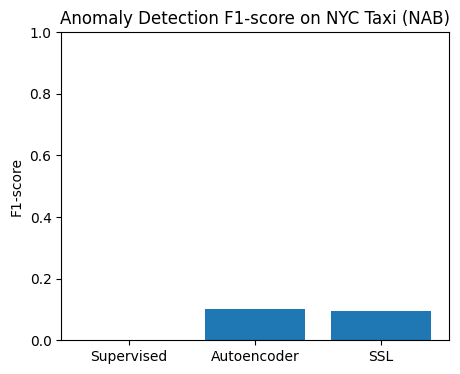

In [18]:
models = ["Supervised", "Autoencoder", "SSL"]
f1s = [sup_f1, ae_f1, ssl_f1]

plt.figure(figsize=(5,4))
plt.bar(models, f1s)
plt.ylim(0, 1.0)
plt.title("Anomaly Detection F1-score on NYC Taxi (NAB)")
plt.ylabel("F1-score")
plt.show()
